# Stock Sentiment Analysis Project

What's the goal of the project?
How do we plan to achieve the goal?
What are some technologies used?

1. Setup
2. Get some data (for whatever stocks and time period we want - prices + articles)
3. Run sentiment analysis on articles
4. Graph stock prices vs. sentiment
  - problem: daily stock price vs. article infrequency
      - possible solutions - use last sentiment
      - possible solutions - reduce stock price data to have the same frequency
      - possible solutions - statistical inferrence (doesn't necessarily need the same frequency)
5. Manually confirm some of the articles (human-defined sentiment vs. sentiment analysis results)
6. [Optional] Re-train the model to better fit
7. [Optional] Experiment with training the model based on different data sources
8. Discuss observations (delay between article and stock changes? ...)
9. Build a "live" monitoring system - top 10 winners or losers vs. articles for them (trending positive or whatever)

# Setup

In [1]:
%matplotlib notebook

# import dependencies (for all of the notebook and remove from elsewhere)
import sys
import pandas as pd
from news_finders import content_scraper
from news_finders import newsApi
from yahoofinancials import YahooFinancials
from utils import helper_functions
from utils import sqlite_utils
from datetime import datetime, timedelta
from stock_historical_data import getStockData
from scrapeTrendingStocks import y_scrape_utils
from matplotlib import pyplot as plt 


connection_article_database = sqlite_utils.setUpArticleDatabase()

connection_pricing_database = sqlite_utils.setUpPricingDatabase()

connection_gainers_database = sqlite_utils.setUpGainersDatabase()

connection_losers_database = sqlite_utils.setUpLosersDatabase()

max_article_date = helper_functions.getMaxDateForStockArticles()

## Gathering the Historical Price and Article Data for User Inputted Stock Tickers
Utilizing the News API service, we gather articles referencing the Stock Symbols that we are interested in. We t ake the JSON data returned, clean it, and store into our sqlite database for future reference.

In [2]:
#STOCKS = ["WMT", "AMZN", "MRNA"]
STOCKS = helper_functions.getStockTickersFromUser()


newsApi.getAndStoreArticlesForMultipleStocks(STOCKS, max_article_date, connection_article_database)


getStockData.getAndStoreMultipleStocksPricingData(STOCKS, connection_pricing_database)

Input individual stock ticker to analyze or multiple comma seperated stock tickers. If done, write 'done'
GOOGL
Input individual stock ticker to analyze or multiple comma seperated stock tickers. If done, write 'done'
done
None


In [3]:
# Test to show the stock article and stock pricing database contents
sqlite_utils.fetchStockDataOverview(connection_pricing_database, connection_article_database, STOCKS)

Ticker   Pricing Rows    Pricing Min Date   Pricing Max Date   Article Rows    Article Min Date   Article Max Date  
GOOGL    4215            2004-08-19         2021-05-17         20              2021-04-22         2021-05-17        


### Pulling Stock Article and Sentiment Data from stockSentiment Database

In [4]:
dataFrame = pd.read_sql_query('SELECT * FROM stockArticles WHERE date >= "2020-03-16" AND date <= "2020-11-14" AND stockSymbol="AAPL" ORDER BY date DESC', connection_article_database)

dataFrame

,stockSymbol,name,url,content,description,scraper,date,sentiment
0,AAPL,Apple introduces iPad Pro with trackpad suppor...,https://www.marketwatch.com/story/apple-introd...,Apple Inc. didnt let the COVID-19 outbreak sto...,Apple Inc. didn’t let the COVID-19 outbreak st...,NewsAPI,2020-03-18,None
1,AAPL,One Wall Street firm just slashed its Apple pr...,https://markets.businessinsider.com/news/stock...,AP Photo/Markus Schreiber\r\n<ul><li>Daniel Iv...,Daniel Ives of Wedbush on Wednesday lowered hi...,NewsAPI,2020-03-18,None
2,AAPL,The oil market's threats combine 9/11 with the...,https://markets.businessinsider.com/news/stock...,Reuters\r\n<ul><li>A race between Saudi Arabia...,A race between Saudi Arabia and Russia to floo...,NewsAPI,2020-03-18,None
3,AAPL,Analyst predicts year-end rebound for AAPL as ...,https://9to5mac.com/2020/03/17/aapl-stock-jump...,AAPL stock fell more than 12% at the market op...,AAPL stock fell more than 12% at the market op...,NewsAPI,2020-03-17,None
4,AAPL,AAPL shares fall 12% at stock market open as A...,https://9to5mac.com/2020/03/16/aapl-shares-fal...,The financial markets continues to be incredib...,The financial markets continues to be incredib...,NewsAPI,2020-03-16,None
5,AAPL,Apple's Stock Has Plunged 25% in Just Over One...,https://www.macrumors.com/2020/03/16/aapl-down...,"With every new operating system update, there ...",Apple's stock opened at $241.31 today and is c...,NewsAPI,2020-03-16,None


### Pulling Stock Price Data from stockPricing Database and Plotting the Data

<IPython.core.display.Javascript object>


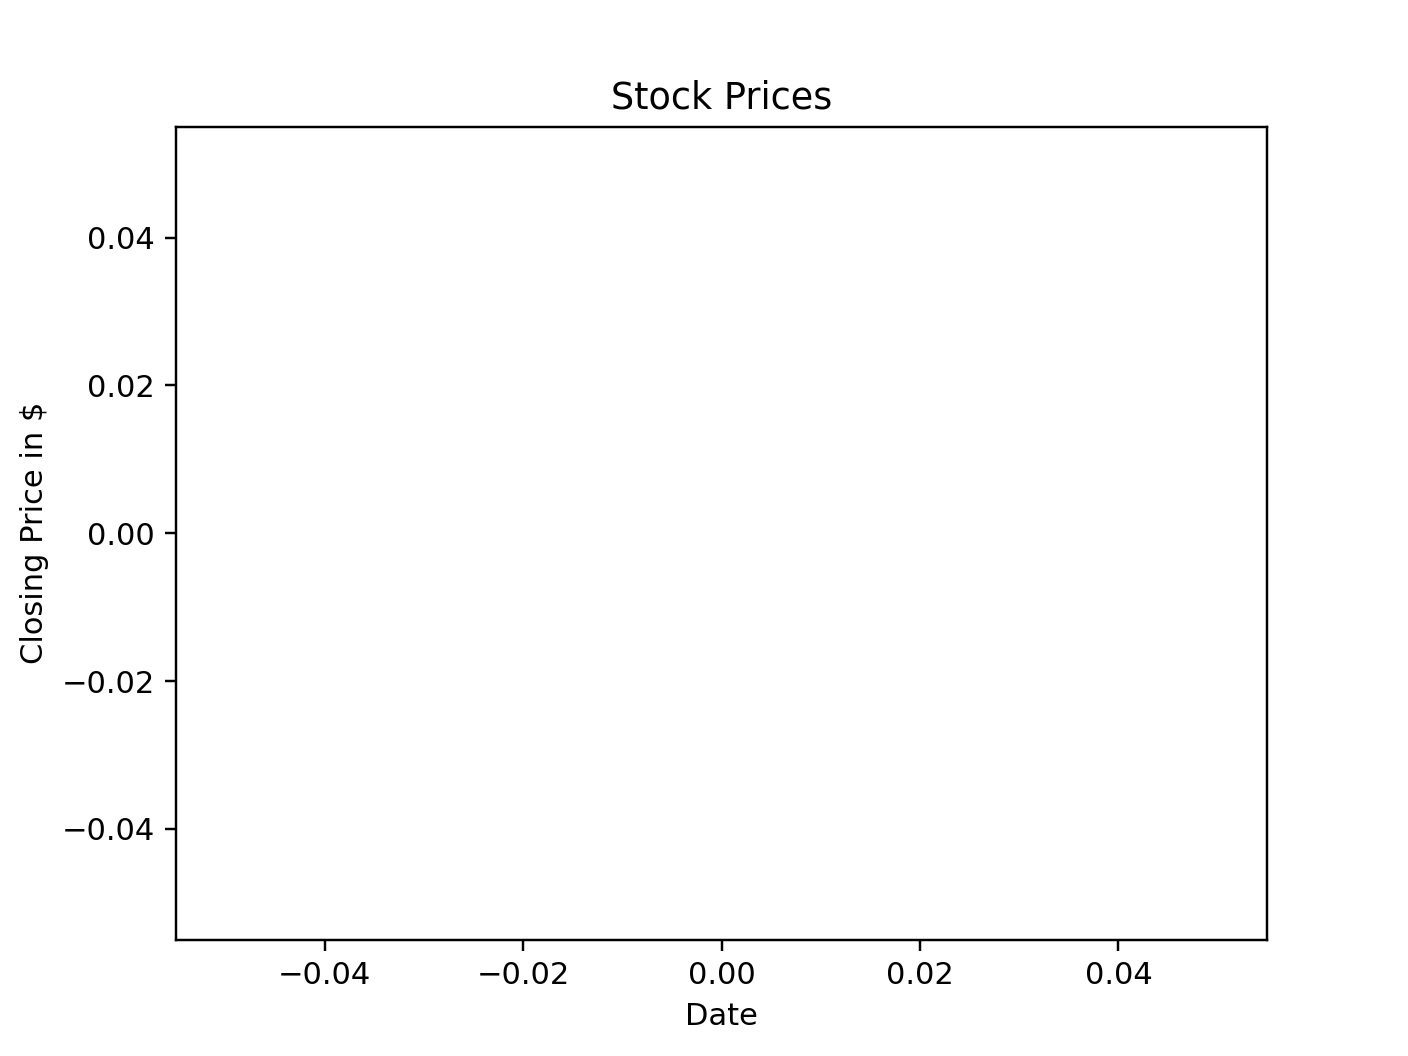

In [6]:
data = sqlite_utils._findAllStockPricingForStockSymbol(connection_pricing_database, "WMT")

# Adding Title 
plt.title("Stock Prices")
  
# Labeling the axes 
plt.xlabel("Date") 
plt.ylabel("Closing Price in $")
     
    
xs = [x[0] for x in data]
ys = [y[1] for y in data]

#print("xs: ", xs)
#print("ys: ", ys)
#plt.autoscale(enable=True, axis='both', tight=None)

# Function to plot  
plt.plot(xs, ys)

# function to show the plot  
plt.show()

### Getting and Storing Top Gaining & Losing Stock on the Hour 

In [7]:
y_scrape_utils.getAndStoreTop25GainingStocks(connection_gainers_database)

y_scrape_utils.getAndStoreTop25LosingStocks(connection_losers_database)

gainers = pd.read_sql_query('SELECT * FROM stockGainers', connection_gainers_database)

losers = pd.read_sql_query('SELECT * FROM stockLosers', connection_losers_database)
                              
gainers

losers

print(sqlite_utils.findMultipleStockGainers(connection_gainers_database))

[]


# Perform sentiment analysis on the articles

In [8]:
from sentiment_analysis_utils import sklearn_sa

# Train the model using data from http://www.cs.jhu.edu/~mdredze/datasets/sentiment
sklearn_sa.Train()

/Users/bcopos/Documents/personal/stockSentimentAnalysis/src/sentiment_analysis_utils/sklearn_sa.py:77: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 77 of the file /Users/bcopos/Documents/personal/stockSentimentAnalysis/src/sentiment_analysis_utils/sklearn_sa.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(data)
/Users/bcopos/Documents/personal/stockSentimentAnalysis/src/sentiment_analysis_utils/sklearn_sa.py:77: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a differe

In [16]:
# Iterate through articles and perform sentiment analysis
articles = sqlite_utils._findStockArticlesForSymbol(connection_article_database, 'GOOGL')
for article in articles:
    symbol, title, url, summary, body, source, date, _ = article
    print(sklearn_sa.Fit(body))
    # The results look like: [(-1, {percentage}), (1, {percentage})]
    # where -1 indicates negative sentiment and 1 indicates positive percentage
    # The percentage indicates how well the text classifies as having a positive or negative sentiment.
    # Typically things with close to 50/50 percentages for -1 and +1 should be ignored as neutral.

[(-1, 0.4169911755435052), (1, 0.5830088244564935)]
[(-1, 0.44108530915369115), (1, 0.5589146908463114)]
[(-1, 0.4854802806212381), (1, 0.5145197193787627)]
[(-1, 0.2587996016630527), (1, 0.7412003983369487)]
[(-1, 0.3090437186169927), (1, 0.6909562813830058)]
[(-1, 0.3176116530064308), (1, 0.6823883469935658)]
[(-1, 0.511382714549024), (1, 0.4886172854509743)]
[(-1, 0.4154415403369238), (1, 0.5845584596630774)]
[(-1, 0.3940773471110283), (1, 0.6059226528889718)]
[(-1, 0.4565016144982887), (1, 0.5434983855017123)]
[(-1, 0.3323170674649065), (1, 0.6676829325350939)]
[(-1, 0.4389821613911718), (1, 0.5610178386088257)]
[(-1, 0.4039648252272772), (1, 0.5960351747727209)]
[(-1, 0.36449759267581805), (1, 0.6355024073241837)]
[(-1, 0.4571993132644492), (1, 0.5428006867355538)]
[(-1, 0.2510031372179844), (1, 0.7489968627820147)]
[(-1, 0.40267197532397836), (1, 0.5973280246760205)]
[(-1, 0.4053237144375342), (1, 0.5946762855624664)]
[(-1, 0.38989988939078074), (1, 0.6101001106092188)]
[(-1, 0.3